In [38]:
import pandas as pd
import numpy as np
import datetime
from fuzzywuzzy import process, fuzz
import geopandas as gpd
from shapely.geometry import Point
from ast import literal_eval

In [3]:
data = pd.read_csv("./Rail_transport_performance_in_Europe_2021.csv")

In [4]:
d = pd.DataFrame(data)

In [5]:
d.head()

,country_larger_city,HDC_code_larger,larger_city,pop_larger_city,country_smaller_city,HDC_code_smaller,smaller_city,pop_smaller_city,crossborder,distance_centroids,av_dist_opti,time_opti,speed_opti,av_dist_avt,time_avt,speed_avt
0,FR,GEOSTAT11_450,Paris,8900172,BE,GEOSTAT11_349,Bruxelles / Brussel,1233487,True,more than 120 km,260.8,1.44,182.1,261.6,1.71,153.5
1,FR,GEOSTAT11_450,Paris,8900172,FR,GEOSTAT11_361,Lille,911478,False,more than 120 km,202.0,1.00,202.1,201.9,1.29,157.3
2,FR,GEOSTAT11_450,Paris,8900172,FR,GEOSTAT11_418,Rouen,298297,False,114.6,110.0,1.24,88.7,110.0,1.67,65.9
3,FR,GEOSTAT11_450,Paris,8900172,FR,GEOSTAT11_434,Cergy-Pontoise,273138,False,30.6,4.8,0.07,67.9,4.8,0.17,27.9
4,FR,GEOSTAT11_450,Paris,8900172,FR,GEOSTAT11_499,Tours,211915,False,more than 120 km,187.7,0.86,218.2,200.4,1.54,130.6


In [6]:
d.isna().sum()

country_larger_city        0
HDC_code_larger            0
larger_city                0
pop_larger_city            0
country_smaller_city       0
HDC_code_smaller           0
smaller_city               0
pop_smaller_city           0
crossborder                0
distance_centroids         0
av_dist_opti            3165
time_opti               3165
speed_opti              3165
av_dist_avt             3165
time_avt                3165
speed_avt               3165
dtype: int64

In [7]:
d['country_larger_city'].value_counts()

UK    2336
NL    1037
DE    1025
ES     496
IT     487
PL     301
FR     287
BE     184
RO      91
CZ      75
CH      68
HU      43
BG      42
SE      30
SK      24
PT      20
AT      16
DK       7
SI       7
LT       5
IE       4
EL       4
FI       3
HR       3
LU       3
NO       1
Name: country_larger_city, dtype: int64

In [8]:
d_cleaned = d.dropna()

## High-speed trains
I will exlclude countries that do not have high-speed trains and focus solely on : Germany, Italy, Spain, UK, France, Finland and Netherlands.

In [9]:
fast_countries = ['DE', 'NL', 'ES', 'IT', 'FR', 'UK', 'FI']
d_fast = d_cleaned[d_cleaned['country_larger_city'].isin(fast_countries)]

In [10]:
d_fast_sorted = d_fast.sort_values(by='speed_opti', ascending=False)
d_fast_sorted

,country_larger_city,HDC_code_larger,larger_city,pop_larger_city,country_smaller_city,HDC_code_smaller,smaller_city,pop_smaller_city,crossborder,distance_centroids,av_dist_opti,time_opti,speed_opti,av_dist_avt,time_avt,speed_avt
9,FR,GEOSTAT11_450,Paris,8900172,FR,GEOSTAT11_475,Le Mans,142171,False,more than 120 km,173.2,0.79,219.3,178.0,1.39,128.8
4,FR,GEOSTAT11_450,Paris,8900172,FR,GEOSTAT11_499,Tours,211915,False,more than 120 km,187.7,0.86,218.2,200.4,1.54,130.6
1,FR,GEOSTAT11_450,Paris,8900172,FR,GEOSTAT11_361,Lille,911478,False,more than 120 km,202.0,1.00,202.1,201.9,1.29,157.3
113,IT,GEOSTAT11_593,Milano,2893231,IT,GEOSTAT11_608,Torino,1154309,False,more than 120 km,121.9,0.62,198.3,127.6,1.50,85.1
115,IT,GEOSTAT11_593,Milano,2893231,IT,GEOSTAT11_630,Bologna,418642,False,more than 120 km,198.1,1.01,197.2,200.8,1.40,143.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5659,ES,GEOSTAT11_745,Sant Boi de Llobregat,79152,ES,GEOSTAT11_750,Castelldefels,62044,False,9.1,9.4,0.84,11.1,9.4,5.27,1.8
5819,NL,GEOSTAT11_231,Ede,75606,NL,GEOSTAT11_228,Veenendaal,60337,False,7.1,9.5,1.03,9.2,9.0,1.32,6.9
3676,NL,GEOSTAT11_207,Amersfoort,140585,NL,GEOSTAT11_202,Soest / Baarn,52792,False,7.0,5.0,0.61,8.3,5.0,0.79,6.3
4619,ES,GEOSTAT11_747,Viladecans,104502,ES,GEOSTAT11_745,Sant Boi de Llobregat,79152,False,4.1,5.7,0.77,7.4,5.7,5.27,1.1


In [11]:
#checking if there are duplicste routes
duplicate_routes = d_fast.duplicated(subset=['larger_city', 'smaller_city'])

print(duplicate_routes.value_counts())

False    3125
dtype: int64


In [12]:
d.nunique()

country_larger_city       26
HDC_code_larger          702
larger_city              702
pop_larger_city          700
country_smaller_city      28
HDC_code_smaller         717
smaller_city             717
pop_smaller_city         716
crossborder                2
distance_centroids      1126
av_dist_opti            1274
time_opti                148
speed_opti              1062
av_dist_avt             1284
time_avt                 353
speed_avt                827
dtype: int64

In [13]:
# Get unique cities from both columns
unique_larger_cities = set(d['larger_city'].unique())
unique_smaller_cities = set(d['smaller_city'].unique())

# Identify common cities
common_cities = unique_larger_cities.intersection(unique_smaller_cities)

# Identify cities unique to each column
unique_to_larger = unique_larger_cities - common_cities
unique_to_smaller = unique_smaller_cities - common_cities

# Print the results
print("Cities Unique to Larger:", unique_to_larger)
print("Cities Unique to Smaller:", unique_to_smaller)

Cities Unique to Larger: {'Vilnius', 'Klaipėda', 'Warszawa', 'Lisboa', 'Cluj-Napoca', 'Iaşi', 'Oradea', 'Koszalin', 'Graz', 'Catania', 'Bilbao', 'Berlin', 'Sevilla', 'Timişoara', 'Ruhrgebiet', 'Bucureşti', 'Palermo', 'Split', 'Århus', 'Sofia', 'Pamplona/Iruña', 'Badajoz', 'Constanţa', 'Barcelona', 'A Coruña', 'Lublin', 'Madrid', 'Nantes', 'München', 'Aberdeen', 'Göteborg', 'Hamburg', 'Białystok', 'Cork', 'Stockholm', 'London', 'Thessaloniki', 'Zürich', 'Helsinki', 'Košice', 'Dijon', 'Poznań', 'Napoli', 'Pécs', 'Amsterdam', 'Valencia', 'Porto', 'Marseille', 'Belfast', 'Wien', 'København', 'Rzeszów', 'Galaţi', 'Plovdiv', 'Zagreb', 'Gdańsk', 'Gijón', 'Lyon', 'Norwich', 'Toulouse', 'Groningen', 'Oslo', 'Górnośląski Związek Metropolitalny', 'Olsztyn', 'Varna', 'Bari', 'Glasgow', 'Pescara', 'Limoges', 'Nice', 'Praha', 'Craiova', 'Szczecin', 'Braşov', 'Dublin', 'Brest', 'Málaga', 'Plymouth', 'Milano', 'Paris', 'Budapest', 'Wrocław'}
Cities Unique to Smaller: {'Lørenskog / Lillestrøm', 'Tübing

## Datasets for geographical coordinates 
for Germany, Italy, Spain, UK, France, Finland and Netherlands.
https://simplemaps.com/resources/free-country-cities

In [14]:
df_de = pd.read_csv('./de.csv')
df_es = pd.read_csv('./es.csv')
df_fi = pd.read_csv('./fi.csv')
df_fr = pd.read_csv('./fr.csv')
df_it = pd.read_csv('./it.csv')
df_nl= pd.read_csv('./nl.csv')
df_gb = pd.read_csv('./gb.csv')

df_geo = pd.concat([df_de, df_es, df_fi, df_fr, df_it, df_nl, df_gb])
df_geo

,city,lat,lng,country,iso2,admin_name,capital,population,population_proper
0,Berlin,52.5200,13.4050,Germany,DE,Berlin,primary,4473101.0,3677472.0
1,Stuttgart,48.7775,9.1800,Germany,DE,Baden-Württemberg,admin,2787724.0,626275.0
2,Munich,48.1375,11.5750,Germany,DE,Bavaria,admin,2606021.0,1487708.0
3,Hamburg,53.5500,10.0000,Germany,DE,Hamburg,admin,2484800.0,1853935.0
4,Cologne,50.9364,6.9528,Germany,DE,North Rhine-Westphalia,NaN,1083498.0,1073096.0
...,...,...,...,...,...,...,...,...,...
675,Harton,54.8810,-1.5340,United Kingdom,GB,South Tyneside,NaN,2878.0,2878.0
676,Kinghorn,56.0700,-3.1700,United Kingdom,GB,Fife,NaN,2840.0,2840.0
677,Appledore,51.0525,-4.1945,United Kingdom,GB,Devon,NaN,2814.0,2814.0
678,New Earswick,53.9920,-1.0724,United Kingdom,GB,York,NaN,2737.0,2737.0


In [15]:
df_geo.isna().sum()

city                    0
lat                     0
lng                     0
country                 0
iso2                    0
admin_name              4
capital              1877
population             23
population_proper      23
dtype: int64

In [16]:
df_geo.nunique()

city                 2560
lat                  2242
lng                  2310
country                 7
iso2                    7
admin_name            286
capital                 3
population           2487
population_proper    2491
dtype: int64

In [17]:
city_geo_dupl = df_geo.duplicated(subset=['city'], keep=False)

# Filter the DataFrame to show only duplicates
duplicates_only = df_geo[city_geo_dupl]

# Display only the rows where city names are duplicated
print(duplicates_only)

           city      lat      lng         country iso2            admin_name  \
123     Moncada  41.4867   2.1879           Spain   ES             Catalonia   
163     Moncada  39.5456  -0.3956           Spain   ES              Valencia   
15    Seinäjoki  62.7917  22.8417         Finland   FI       Etelä-Pohjanmaa   
167        Juva  61.8972  27.8569         Finland   FI            Etelä-Savo   
245   Seinäjoki  62.5667  23.0667         Finland   FI       Etelä-Pohjanmaa   
340        Juva  60.8667  23.0000         Finland   FI       Varsinais-Suomi   
230      Grigny  48.6562   2.3849          France   FR         Île-de-France   
491      Grigny  45.6083   4.7897          France   FR  Auvergne-Rhône-Alpes   
249  Wellington  52.7001  -2.5157  United Kingdom   GB    Telford and Wrekin   
278     Clifton  52.9040  -1.1770  United Kingdom   GB            Nottingham   
313       Hythe  50.8690  -1.3990  United Kingdom   GB             Hampshire   
315    Rothwell  53.7485  -1.4780  Unite

Trying to match the datsets by city

In [18]:
larger_cities = set(d['larger_city'].unique())
geo_cities = set(df_geo['city'].unique())

# matching cities in both datasets
matching_cities = larger_cities.intersection(geo_cities)

matching_count = len(matching_cities)

print("Number of matching larger cities in both datasets:", matching_count)
print("Matching Cities:", matching_cities)

Number of matching larger cities in both datasets: 292
Matching Cities: {'Granada', 'Birmingham', 'Freiburg im Breisgau', 'Rotterdam', 'Duisburg', 'Harrogate', 'Osnabrück', 'Düsseldorf', 'Zwolle', 'Bremerhaven', 'Almere', 'Taranto', 'Pau', 'Hoorn', 'Le Havre', 'Lorient', 'Maidstone', 'Poissy', 'Lille', 'Derby', 'Reus', 'Valladolid', 'Prato', 'Arras', 'Leicester', 'Logroño', 'Lelystad', 'Acireale', 'Saronno', 'Mulhouse', 'Neuss', 'Eindhoven', 'Elda', 'Catania', 'Rouen', 'San Giuseppe Vesuviano', 'Jaén', 'Oxford', 'Salerno', 'Berlin', 'Cartagena', 'Heilbronn', 'Bilbao', 'Torremolinos', 'Sevilla', 'Besançon', 'Guadalajara', 'Wiesbaden', 'Bath', 'Hereford', 'Chartres', 'Palermo', 'Piacenza', 'Rostock', 'Montpellier', 'Torrevieja', 'Carlisle', 'Sabadell', 'Troyes', 'Hilversum', 'Ferrara', 'Alkmaar', 'Benidorm', 'Oviedo', 'Cádiz', 'Erlangen', 'Bolzano', 'Burgos', 'Valence', 'Rennes', 'Foggia', 'Zaragoza', 'Chester', 'Meaux', 'Torrejón de Ardoz', 'Stuttgart', 'Mainz', 'Hagen', 'Alcalá de Hena

In [19]:
def get_closest_match(x, choices, scorer, cutoff):
    match = process.extractOne(x, choices, scorer=scorer, score_cutoff=cutoff)
    return match[0] if match else None

# Example of getting the closest match for 'larger_city'
d['larger_city_matched'] = d['larger_city'].apply(lambda x: get_closest_match(x, df_geo['city'], fuzz.token_sort_ratio, cutoff=80))

In [20]:
print(d[['larger_city', 'larger_city_matched']].head(20))

   larger_city larger_city_matched
0        Paris               Paris
1        Paris               Paris
2        Paris               Paris
3        Paris               Paris
4        Paris               Paris
5        Paris               Paris
6        Paris               Paris
7        Paris               Paris
8        Paris               Paris
9        Paris               Paris
10       Paris               Paris
11       Paris               Paris
12       Paris               Paris
13       Paris               Paris
14       Paris               Paris
15       Paris               Paris
16       Paris               Paris
17       Paris               Paris
18       Paris               Paris
19       Paris               Paris


In [21]:
matched_count = d['larger_city_matched'].notnull().sum()
print("Number of Matched Cities:", matched_count)

Number of Matched Cities: 3888


In [22]:
# Function to get the closest match
def get_closest_match(x, choices, scorer, cutoff):
    match = process.extractOne(x, choices, scorer=scorer, score_cutoff=cutoff)
    return match[0] if match else None

# Apply fuzzy matching to the 'smaller_city' column
d['smaller_city_matched'] = d['smaller_city'].apply(lambda x: get_closest_match(x, df_geo['city'], fuzz.token_sort_ratio, cutoff=80))

# Count the number of matched cities
matched_smaller_cities_count = d['smaller_city_matched'].notnull().sum()
print("Number of Matched Smaller Cities:", matched_smaller_cities_count)

Number of Matched Smaller Cities: 3341


## Merging databases

In [23]:
# Merge latitude and longitude for larger cities
d = d.merge(df_geo[['city', 'lat', 'lng']], left_on='larger_city_matched', right_on='city', how='left')
d.rename(columns={'lat': 'larger_city_lat', 'lng': 'larger_city_lng'}, inplace=True)
d.drop(columns=['city'], inplace=True)  # drop the duplicate city column

# Merge latitude and longitude for smaller cities
d = d.merge(df_geo[['city', 'lat', 'lng']], left_on='smaller_city_matched', right_on='city', how='left')
d.rename(columns={'lat': 'smaller_city_lat', 'lng': 'smaller_city_lng'}, inplace=True)
d.drop(columns=['city'], inplace=True)  # drop the duplicate city column

# Check the first few rows of the dataframe
print(d.head())

  country_larger_city HDC_code_larger larger_city  pop_larger_city  \
0                  FR   GEOSTAT11_450       Paris          8900172   
1                  FR   GEOSTAT11_450       Paris          8900172   
2                  FR   GEOSTAT11_450       Paris          8900172   
3                  FR   GEOSTAT11_450       Paris          8900172   
4                  FR   GEOSTAT11_450       Paris          8900172   

  country_smaller_city HDC_code_smaller         smaller_city  \
0                   BE    GEOSTAT11_349  Bruxelles / Brussel   
1                   FR    GEOSTAT11_361                Lille   
2                   FR    GEOSTAT11_418                Rouen   
3                   FR    GEOSTAT11_434       Cergy-Pontoise   
4                   FR    GEOSTAT11_499                Tours   

   pop_smaller_city  crossborder distance_centroids  ...  speed_opti  \
0           1233487         True   more than 120 km  ...       182.1   
1            911478        False   more than 120 k

In [24]:
d.nunique()

country_larger_city       26
HDC_code_larger          702
larger_city              702
pop_larger_city          700
country_smaller_city      28
HDC_code_smaller         717
smaller_city             717
pop_smaller_city         716
crossborder                2
distance_centroids      1126
av_dist_opti            1274
time_opti                148
speed_opti              1062
av_dist_avt             1284
time_avt                 353
speed_avt                827
larger_city_matched      340
smaller_city_matched     336
larger_city_lat          329
larger_city_lng          334
smaller_city_lat         325
smaller_city_lng         329
dtype: int64

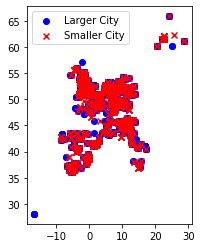

In [25]:
geometry_larger = [Point(xy) for xy in zip(d.larger_city_lng, d.larger_city_lat)]
geo_df_larger = gpd.GeoDataFrame(d, crs="EPSG:4326", geometry=geometry_larger)

# Create a GeoDataFrame for smaller cities
geometry_smaller = [Point(xy) for xy in zip(d.smaller_city_lng, d.smaller_city_lat)]
geo_df_smaller = gpd.GeoDataFrame(d, crs="EPSG:4326", geometry=geometry_smaller)

# Plotting
base = geo_df_larger.plot(color='blue', marker='o', label='Larger City')
geo_df_smaller.plot(ax=base, color='red', marker='x', label='Smaller City')

base.legend()

In [33]:
fd = pd.read_csv('./flight_times.csv')
matching = pd.read_csv('./airport-codes.csv')
matching

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435.0,NaN,US,US-KS,Leoti,00AA,NaN,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450.0,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,820.0,NaN,US,US-AL,Harvest,00AL,NaN,00AL,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Newport Hospital & Clinic Heliport,237.0,NaN,US,US-AR,Newport,NaN,NaN,NaN,"-91.254898, 35.6087"
...,...,...,...,...,...,...,...,...,...,...,...,...
57416,ZYYK,medium_airport,Yingkou Lanqi Airport,0.0,AS,CN,CN-21,Yingkou,ZYYK,YKH,NaN,"122.3586, 40.542524"
57417,ZYYY,medium_airport,Shenyang Dongta Airport,NaN,AS,CN,CN-21,Shenyang,ZYYY,NaN,NaN,"123.49600219726562, 41.784400939941406"
57418,ZZ-0001,heliport,Sealand Helipad,40.0,EU,GB,GB-ENG,Sealand,NaN,NaN,NaN,"1.4825, 51.894444"
57419,ZZ-0002,small_airport,Glorioso Islands Airstrip,11.0,AF,TF,TF-U-A,Grande Glorieuse,NaN,NaN,NaN,"47.296388888900005, -11.584277777799999"


In [34]:
fd

,Unnamed: 0,route,time
0,0,"{'AAL', 'AMS'}",85.0
1,1,"{'AAQ', 'LED'}",170.0
2,2,"{'AMS', 'ABZ'}",85.0
3,3,"{'ABZ', 'LGW'}",95.0
4,4,"{'ACE', 'AGP'}",130.0
...,...,...,...
1464,1464,"{'ZRH', 'OTP'}",150.0
1465,1465,"{'ZRH', 'PRN'}",127.5
1466,1466,"{'ZRH', 'RVN'}",205.0
1467,1467,"{'ZRH', 'STR'}",45.0


In [39]:
airport_to_city = matching[['iata_code', 'municipality']].dropna().set_index('iata_code')['municipality'].to_dict()

# Clean the flight times data by extracting airport codes and converting them to a list
fd['route'] = fd['route'].apply(lambda x: list(literal_eval(x)))
fd['from_airport'] = fd['route'].apply(lambda x: x[0])
fd['to_airport'] = fd['route'].apply(lambda x: x[1])

# Create a new column for city names based on the airport codes
fd['from_city'] = fd['from_airport'].map(airport_to_city)
fd['to_city'] = fd['to_airport'].map(airport_to_city)

# Now merge this information with your main dataset 'd' by matching the city names
d = d.merge(fd[['from_city', 'to_city', 'time']], left_on=['larger_city', 'smaller_city'], right_on=['from_city', 'to_city'], how='left')

In [43]:
print(d[['larger_city', 'smaller_city', 'from_city', 'to_city', 'time']].head())

# Check for the number of non-null values in the 'time' column to ensure some merges happened
print(d['time'].notnull().sum())

# Check for any null values in the new columns to see if there are missing matches
print(d[['from_city', 'to_city', 'time']].isnull().sum())

# Validate the merge by comparing a few entries manually
# This step is to manually verify if the merge has logically correct matches
# You would replace 'City_Name1' and 'City_Name2' with actual city names from your dataset
print(d[(d['larger_city'] == 'City_Name1') & (d['smaller_city'] == 'City_Name2')])

  larger_city         smaller_city from_city to_city  time
0       Paris  Bruxelles / Brussel       NaN     NaN   NaN
1       Paris                Lille       NaN     NaN   NaN
2       Paris                Rouen       NaN     NaN   NaN
3       Paris       Cergy-Pontoise       NaN     NaN   NaN
4       Paris                Tours       NaN     NaN   NaN
1
from_city    6598
to_city      6598
time         6598
dtype: int64
Empty DataFrame
Columns: [country_larger_city, HDC_code_larger, larger_city, pop_larger_city, country_smaller_city, HDC_code_smaller, smaller_city, pop_smaller_city, crossborder, distance_centroids, av_dist_opti, time_opti, speed_opti, av_dist_avt, time_avt, speed_avt, larger_city_matched, smaller_city_matched, larger_city_lat, larger_city_lng, smaller_city_lat, smaller_city_lng, from_city, to_city, time]
Index: []

[0 rows x 25 columns]
